In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith tavily-python langchain_tavily matplotlib langchain_experimental

In [1]:
# Set environment variables for tracing via LangSmith

import os

os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_PROJECT'] = 'gb-researcher'

In [20]:
# Define tools

from langchain_tavily import TavilySearch
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearch(
    max_results=2,
    search_depth="basic",  # 搜索深度: "basic" 或 "advanced"
    include_answer=True,  # 包含AI生成的答案
    include_raw_content=False,  # 不包含原始HTML内容
    include_images=False  # 不包含图片链接
)

python_repl = PythonREPL()

repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

In [31]:
# Auxiliary Functions

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def agent_node(state, agent, name):
    name = name.replace(' ', '_').replace('-', '_')

    result = agent.invoke(state)

    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.model_dump(exclude={'type', 'name'}), name=name)

    return {
        'messages': [result],
        'sender': name
    }

def create_agent(llm, tools, tool_message, custom_notice=''):

    prompt = ChatPromptTemplate.from_messages([
        (
            'system', 
            'You are a helpful assistant that can answer questions and perform tasks using Python code. You can also search the web for information. If you need to use a tool, you will be provided with the necessary details.'
            'If you have the final answer or deliverable, prefix your response with "FINAL ANSWER" so that the team knows to stop.'
            '\n{custom_notice}\n'
            'You have access to the following tools: {tool_names}.\n{tool_message}\n\n'
        ),
        MessagesPlaceholder(variable_name="messages"),
    ])

    prompt = prompt.partial(tool_message=tool_message, custom_notice=custom_notice, tool_names=', '.join([tool.name for tool in tools]))

    return prompt | llm.bind_tools(tools)

In [22]:
# Create llms for agents

from langchain_openai import ChatOpenAI

research_llm = ChatOpenAI(model='gpt-4o-mini')
chart_llm = ChatOpenAI(model='gpt-4o-mini')

In [23]:
# Research Agent

import functools

research_agent = create_agent(
    llm=research_llm,
    tools=[tavily_tool],
    tool_message=(
        'Before using search engines, please carefully think through and clarify the query, then conduct a single search that addresses all aspects for the query in one go.'
    ),
    custom_notice=(
        'Notice:\n'
        'Only gather and organize information. Do not generate code or give final conclusions, leave it to other assistants.'
    )
)

research_node = functools.partial(agent_node, agent=research_agent, name='Researcher')

In [24]:
# Chart Agent

chart_agent = create_agent(
    llm=chart_llm,
    tools=[repl_tool],
    tool_message=(
        'Create clear and user-friendly charts baed on the provided data.'
    ),
    custom_notice=(
        'Notice:\n'
        'If all tasks completed, respond with "FINAL ANSWER".'
    )
)

chart_node = functools.partial(agent_node, agent=chart_agent, name='Chart')

In [25]:
# Tool call Agent

from langgraph.prebuilt import ToolNode

tools = [tavily_tool, repl_tool]

tool_node = ToolNode(tools=tools)

In [26]:
# Agent State

import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


In [32]:
# Create graph

from langgraph.graph import StateGraph

flow = StateGraph(AgentState)

flow.add_node('Researcher', research_node)
flow.add_node('Chart', chart_node)
flow.add_node('Tool', tool_node)


In [33]:
# Router

from typing import Literal
from langgraph.graph import START, END

def router(state) ->Literal['Researcher', 'Chart', 'Tool']:
    messages = state['messages']
    last_message = messages[-1] if messages else None

    if last_message:
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            return 'Tool'

        if hasattr(last_message, 'content') and 'FINAL ANSWER' in last_message.content:
            return END
        
    return 'continue'


flow.add_conditional_edges(
    'Researcher',
    router,
    {
        'continue': 'Chart',
        'Tool': 'Tool',
        END: END
    }
)

flow.add_conditional_edges(
    'Chart',
    router,
    {
        'continue': 'Researcher',
        'Tool': 'Tool',
        END: END
    }
)

flow.add_conditional_edges(
    'Tool',
    lambda x: x['sender'],
    {
        'Researcher': 'Researcher',
        'Chart': 'Chart'
    }
)

flow.add_edge(START, 'Researcher')

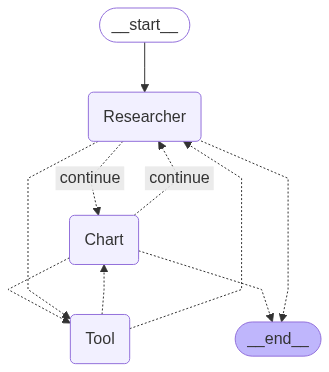

In [34]:
# Compile graph

from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

checkpoint = MemorySaver()

graph = flow.compile(checkpointer=checkpoint)

try: 
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then plot a line chart with Python.
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search (call_iCoEXbPzrkQeE9svmdF7FNbP)
 Call ID: call_iCoEXbPzrkQeE9svmdF7FNbP
  Args:
    query: United States GDP from 2000 to 2020
    search_depth: advanced
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search (call_iCoEXbPzrkQeE9svmdF7FNbP)
 Call ID: call_iCoEXbPzrkQeE9svmdF7FNbP
  Args:
    query: United States GDP from 2000 to 2020
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "United States GDP from 2000 to 2020", "follow_up_questions": null, "answer": "U.S. GDP in 2020 was 21.323 trillion dollars. It declined by 0.92% from 

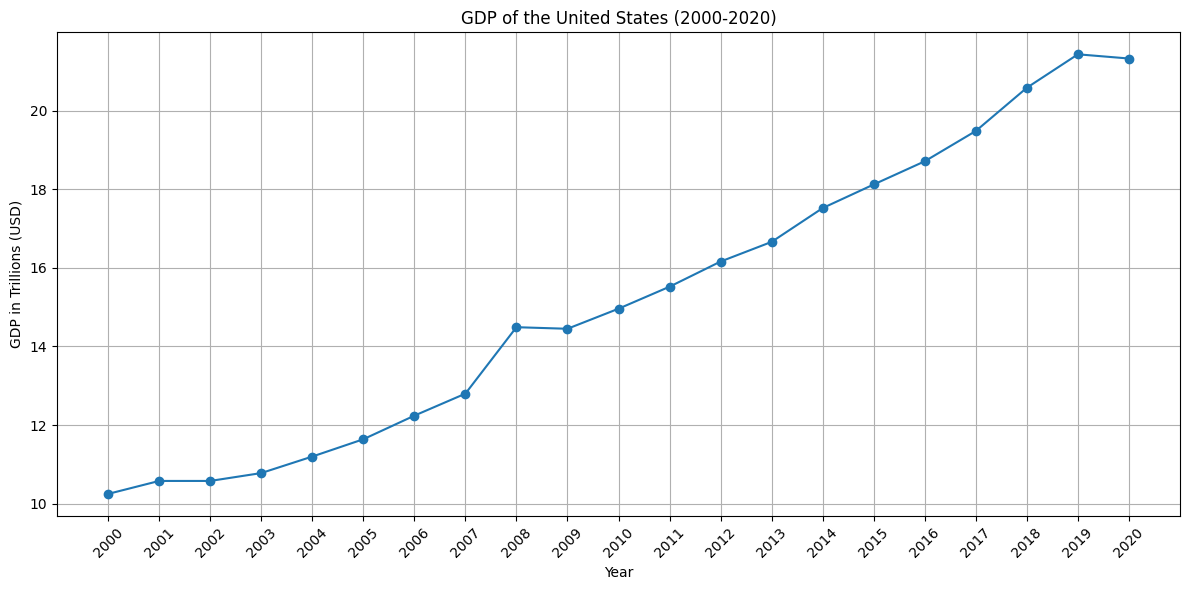

================================= Tool Message =================================
Name: python_repl


================================== Ai Message ==================================
Name: Chart

The line chart displaying the GDP of the United States from 2000 to 2020 has been successfully plotted. It illustrates the growth trends in GDP over the years. 

If you need any further modifications or additional information, let me know! 

FINAL ANSWER
================================== Ai Message ==================================
Name: Chart

The line chart displaying the GDP of the United States from 2000 to 2020 has been successfully plotted. It illustrates the growth trends in GDP over the years. 

If you need any further modifications or additional information, let me know! 

FINAL ANSWER


In [36]:
# Execute MA workflow

from langchain_core.messages import HumanMessage
from uuid import uuid4

thread_id = str(uuid4())

config = {
    'configurable': {
        'thread_id': thread_id,
    },
    'recursion_limit': 10
}

events = graph.stream(
    input={
        'messages': [
            HumanMessage(
                'Obtain the GDP of the United States from 2000 to 2020, and then plot a line chart with Python.'
            )
        ]
    },
    config=config,
    stream_mode='values'
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

In [19]:
repl_tool.name

'Python_REPL'